In [1]:
import glob
import pandas as pd
import numpy as np
import anndata as ad
import muon
import scanpy as sc
import scanpy.external as sce
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scanpy.external as sce
import pathlib
params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 10,
    'font.family': "Arial",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 100
   }

mpl.rcParams.update(params)

sns.set_style("ticks")
sns.set_context(context='paper')
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0, "transparent": True}
mpl.rc('savefig', dpi=300)
output_dir='../../figures/'
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
output_suffix = ""
output_formats = [".png", ".svg"]
sc.settings.figdir = output_dir
sc.set_figure_params(format='pdf', transparent=True,)
def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20) 
pd.set_option('display.width', 100)
%load_ext autoreload
%autoreload 2

In [2]:
%run _helper.py

In [3]:
adatas = []
subsample = False
for file in glob.glob("/home/michaelswift/repos/tabula-bursa/analysis/notebooks/by_tissue_qc/outputs/tissue_objs/*Bcells*h5ad"):
    print(file)
    # do the routine:
    # load data
    adata = sc.read_h5ad(file)
    # subsample based on being large amount of cells
    if subsample:
        if adata.shape[0] > 10000:
            sc.pp.subsample(adata, fraction=1)
    adatas.append(adata)
adata = ad.concat(adatas)

/home/michaelswift/repos/tabula-bursa/analysis/notebooks/by_tissue_qc/outputs/tissue_objs/BM_Bcells_Filtered.h5ad
/home/michaelswift/repos/tabula-bursa/analysis/notebooks/by_tissue_qc/outputs/tissue_objs/LN_Bcells_Filtered.h5ad
/home/michaelswift/repos/tabula-bursa/analysis/notebooks/by_tissue_qc/outputs/tissue_objs/SP_Bcells_Filtered.h5ad
/home/michaelswift/repos/tabula-bursa/analysis/notebooks/by_tissue_qc/outputs/tissue_objs/PB_Bcells_Filtered.h5ad


In [4]:
adata = reformat_adata_obs(adata)

In [5]:
adata.obs.majority_voting.value_counts()

Memory B cells                          133832
Naive B cells                            82989
Plasma cells                             17441
Age-associated B cells                    7100
Plasmablasts                              5089
Age-associated B cells|Naive B cells      1650
Memory B cells|Naive B cells               385
Memory B cells|Plasma cells                372
Unassigned                                   4
Name: majority_voting, dtype: int64

In [20]:
df = adata.obs[['sample_uid', 'majority_voting', 'n_genes', 'total_counts', 'total_counts_mt' ]]

In [21]:
df.to_csv('/home/michaelswift/repos/tabula-bursa/analysis/notebooks/bcells_vdj_integration.tab', sep='\t')

sample_uid majority_voting  n_genes  total_counts  total_counts_mt
AAACCTGAGCCAACAG-1     TBd3_fresh_B20    Plasma cells     1896       16640.0            197.0
AAACCTGAGTCAAGCG-1     TBd3_fresh_B20  Memory B cells     1116        2168.0             88.0
AAACCTGCACCGAAAG-1     TBd3_fresh_B20    Plasma cells     2159        7530.0            373.0
AAACCTGGTCATATGC-1     TBd3_fresh_B20  Memory B cells     1244        2536.0            112.0
AAACCTGGTCGGCATC-1     TBd3_fresh_B20    Plasma cells     2686       14289.0            265.0
...                               ...             ...      ...           ...              ...
TTTGTCATCATTCACT-1-1  TBd6_fresh_PBMC    Plasma cells     4839       31157.0            740.0
TTTGTCATCCGCAAGC-1    TBd6_fresh_PBMC   Naive B cells     3266        8680.0            191.0
TTTGTCATCCGCATCT-1-1  TBd6_fresh_PBMC   Naive B cells     1940        4226.0             98.0
TTTGTCATCGTTACGA-1-1  TBd6_fresh_PBMC   Naive B cells     1778        4280.0            119.0
TTTGTCATCTTCTGGC-1-1  TBd6_fresh_PBMC   Naive B cells     3380       10195.0            505.0

[248862 rows x 5 columns]

In [5]:
adata.obs['donor_tissue'] = adata.obs.donor.astype(str) + adata.obs.tissue.astype(str)

In [6]:
import scvi

Global seed set to 0
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [7]:
scvi.model.SCVI.setup_anndata(adata, layer="umi_counts", batch_key="donor_tissue")

# reset X to umi counts and preprocess everyone similarly

## Because the Adata Interface is clunky and We'll be adding the other modalities soon i'm switching to mdata

In [8]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata

In [9]:
mdata = muon.MuData({"rna": adata.copy(), "log_norm_rna": adata.copy()}, axis=-1)
# Now rna is count-based and log_norm_rna is log-normalized
mdata.mod["rna"].X = mdata.mod["rna"].layers["umi_counts"]
del mdata.mod["rna"].raw
del mdata.mod["rna"].layers["umi_counts"]
del mdata.mod["log_norm_rna"].layers["umi_counts"]
mdata

/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/mudata/_core/mudata.py:289: UserWarning: Duplicated obs_names should not be present in different modalities due to the ambiguity that leads to.
  warnings.warn(
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/mudata/_core/mudata.py:289: UserWarning: Duplicated obs_names should not be present in different modalities due to the ambiguity that leads to.
  warnings.warn(
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/mudata/_core/mudata.py:446: UserWarning: obs_names are not unique. To make them unique, call `.obs_names_make_unique`.
  warnings.warn(
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/mudata/_core/mu

MuData object with n_obs × n_vars = 114957 × 36601
  2 modalities
    rna:	114957 x 36601
      obs:	'sample_uid', 'donor', 'tissue', 'leiden', 'predicted_labels', 'majority_voting', 'conf_score', 'over_clustering', 'donor_tissue', '_scvi_batch', '_scvi_labels'
      uns:	'_scvi_uuid', '_scvi_manager_uuid', 'log1p'
      obsm:	'X_pca', 'X_umap'
    log_norm_rna:	114957 x 36601
      obs:	'sample_uid', 'donor', 'tissue', 'leiden', 'predicted_labels', 'majority_voting', 'conf_score', 'over_clustering', 'donor_tissue', '_scvi_batch', '_scvi_labels'
      uns:	'_scvi_uuid', '_scvi_manager_uuid', 'log1p'
      obsm:	'X_pca', 'X_umap'

In [10]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
pearson_residuals = False
if pearson_residuals:
    adata = adata[:,~adata.var.index.str.contains("IGH|IGL|IGK|AC|AL")].copy()
    sc.experimental.pp.recipe_pearson_residuals(adata, batch_key='tissue')
else:
    sc.pp.highly_variable_genes(adata, batch_key='donor')
    adata = adata[:,~adata.var.index.str.contains("IGL|IGK|AC|AL|HSP|DNAJB|FOS|JUN|JUNB|RPS26|XIST")].copy()
    adata.raw = adata

### light-weight batch correction by choosing HVGs from different tissues



/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scan

In [11]:
sc.pp.scale(adata, max_value=5)

In [12]:
sc.pp.pca(adata)

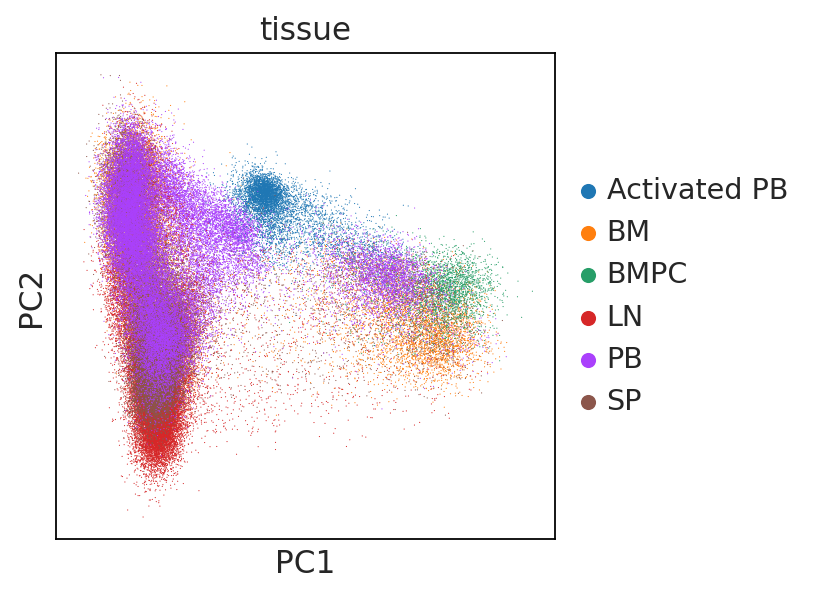

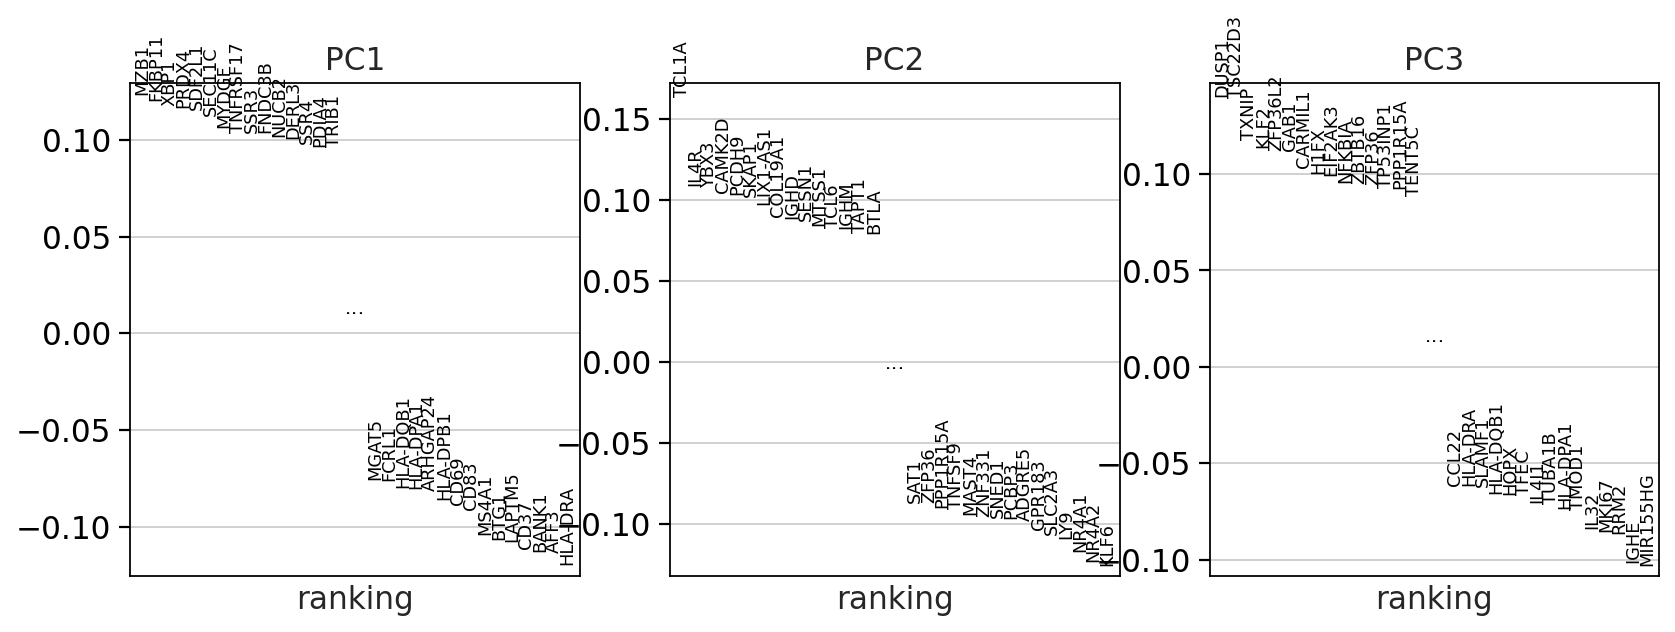

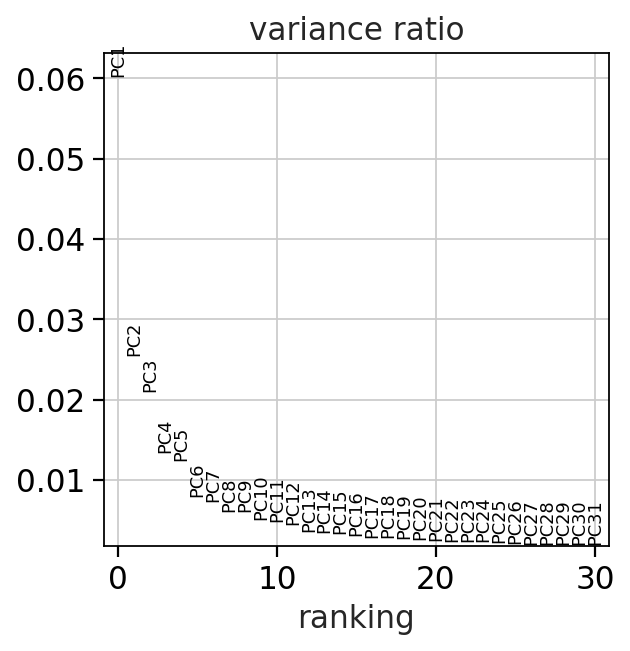

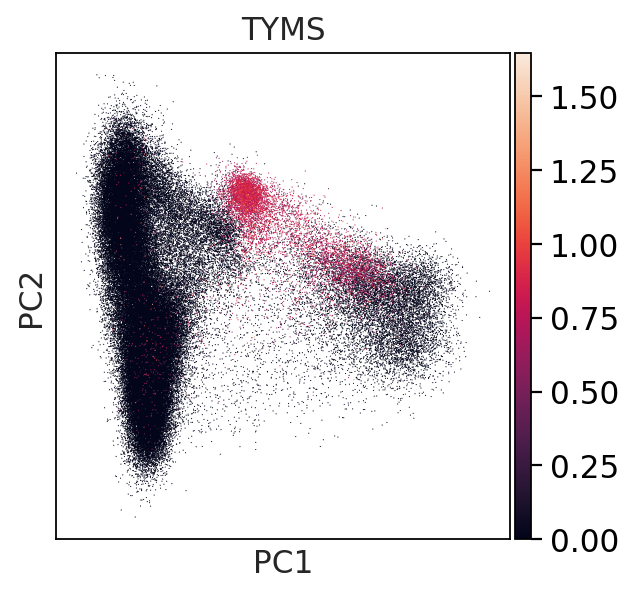

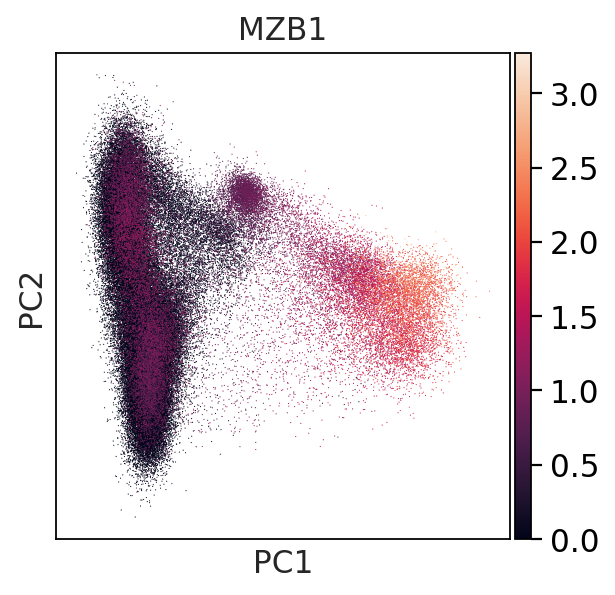

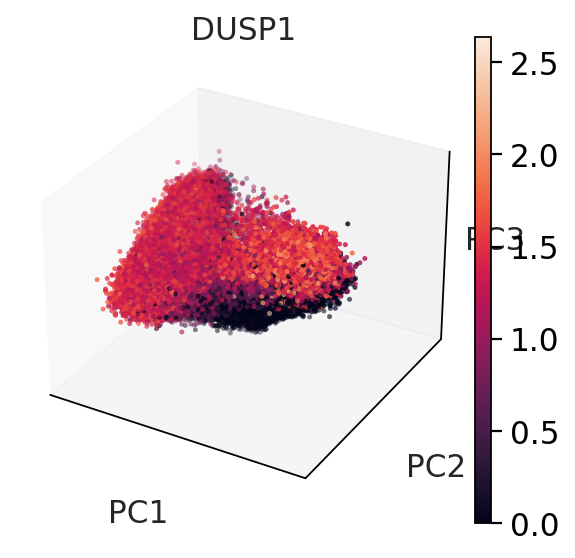

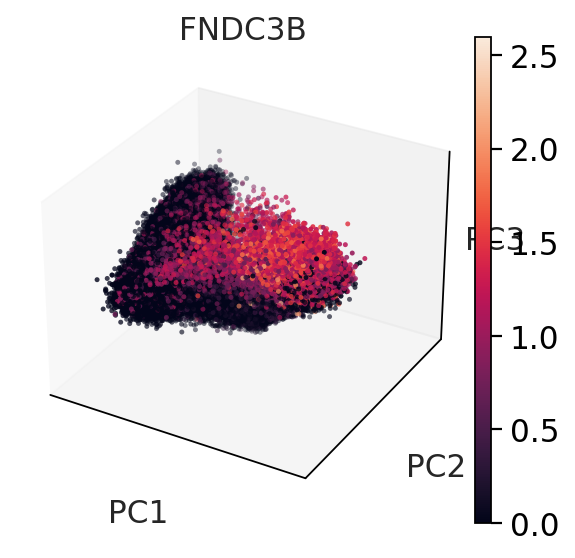

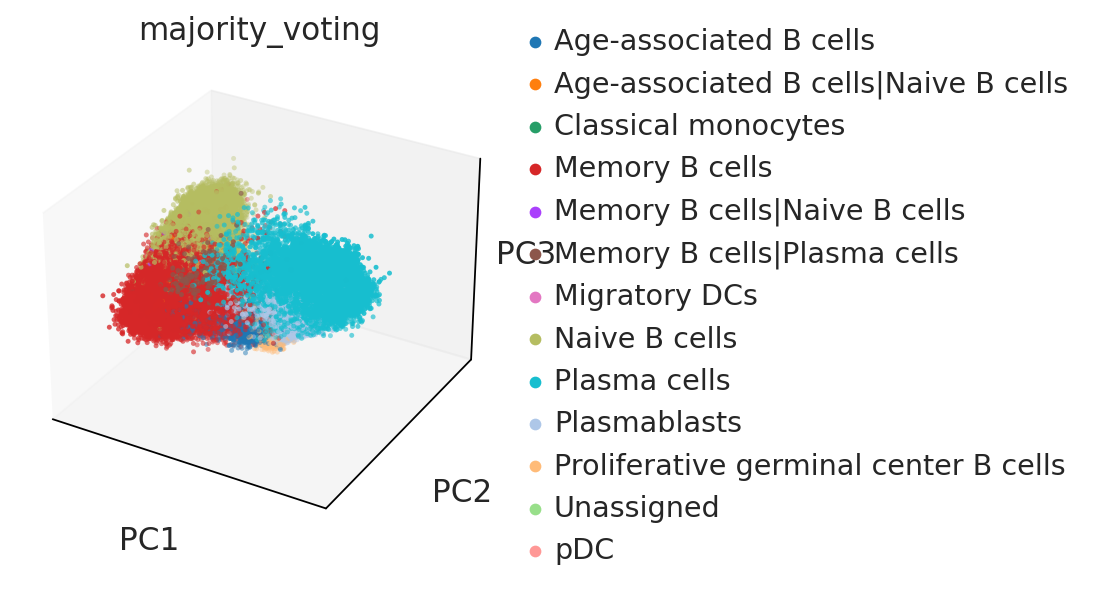

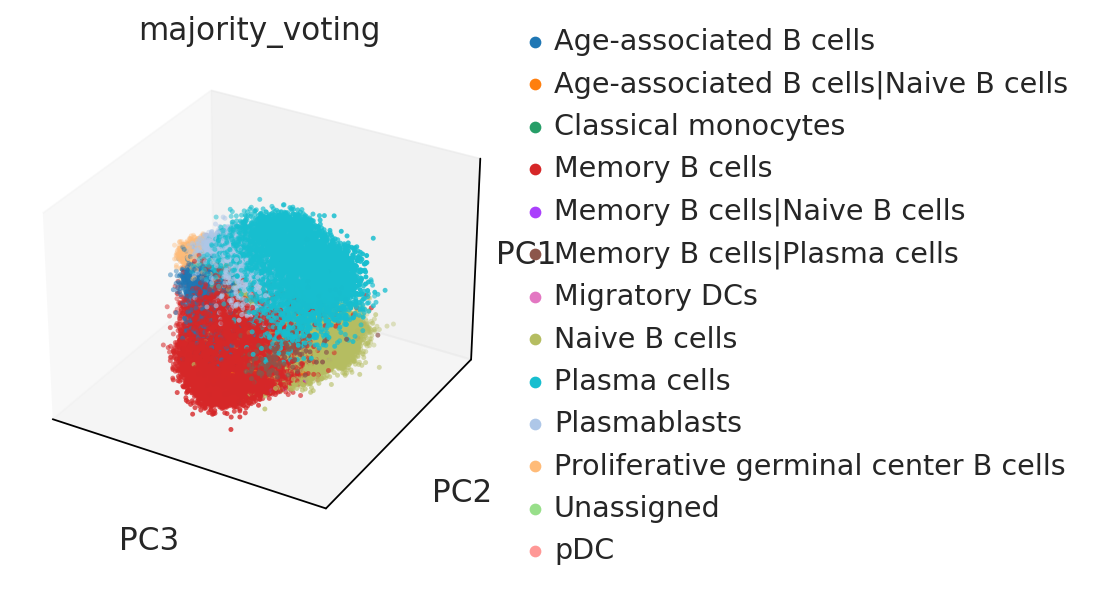

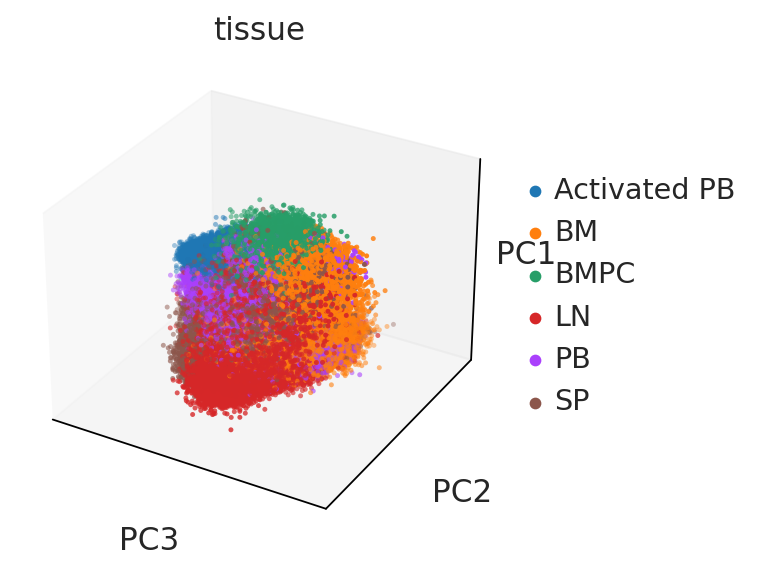

In [13]:
sc.pl.pca_overview(adata, color = 'tissue')
sc.pl.pca_scatter(adata, color = 'TYMS')
sc.pl.pca_scatter(adata, color = 'MZB1')
sc.pl.pca_scatter(adata, color = 'DUSP1', projection='3d')
sc.pl.pca_scatter(adata, color = 'FNDC3B', projection='3d')
sc.pl.pca_scatter(adata, color = 'majority_voting', projection='3d')
sc.pl.pca_scatter(adata, color = 'majority_voting', projection='3d', components='3,2,1')
sc.pl.pca_scatter(adata, color = 'tissue', projection='3d', components='3,2,1')

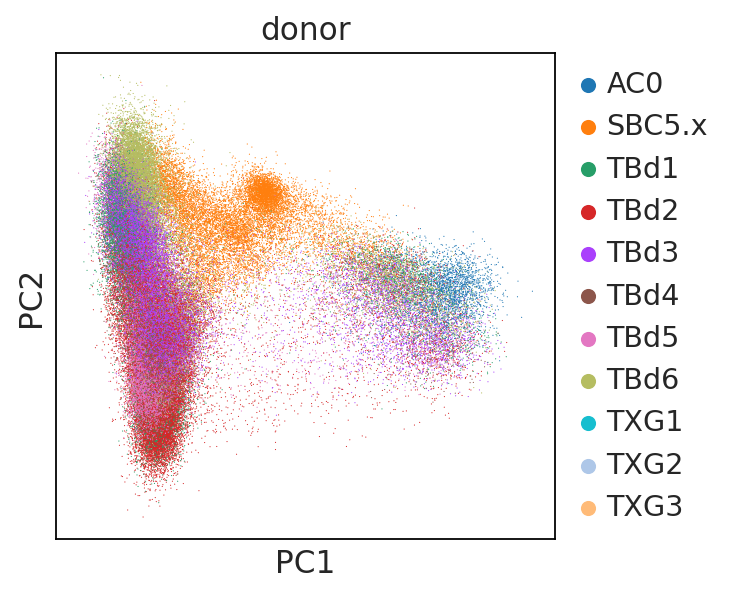

In [14]:
sc.pl.pca_scatter(adata, color = 'donor')

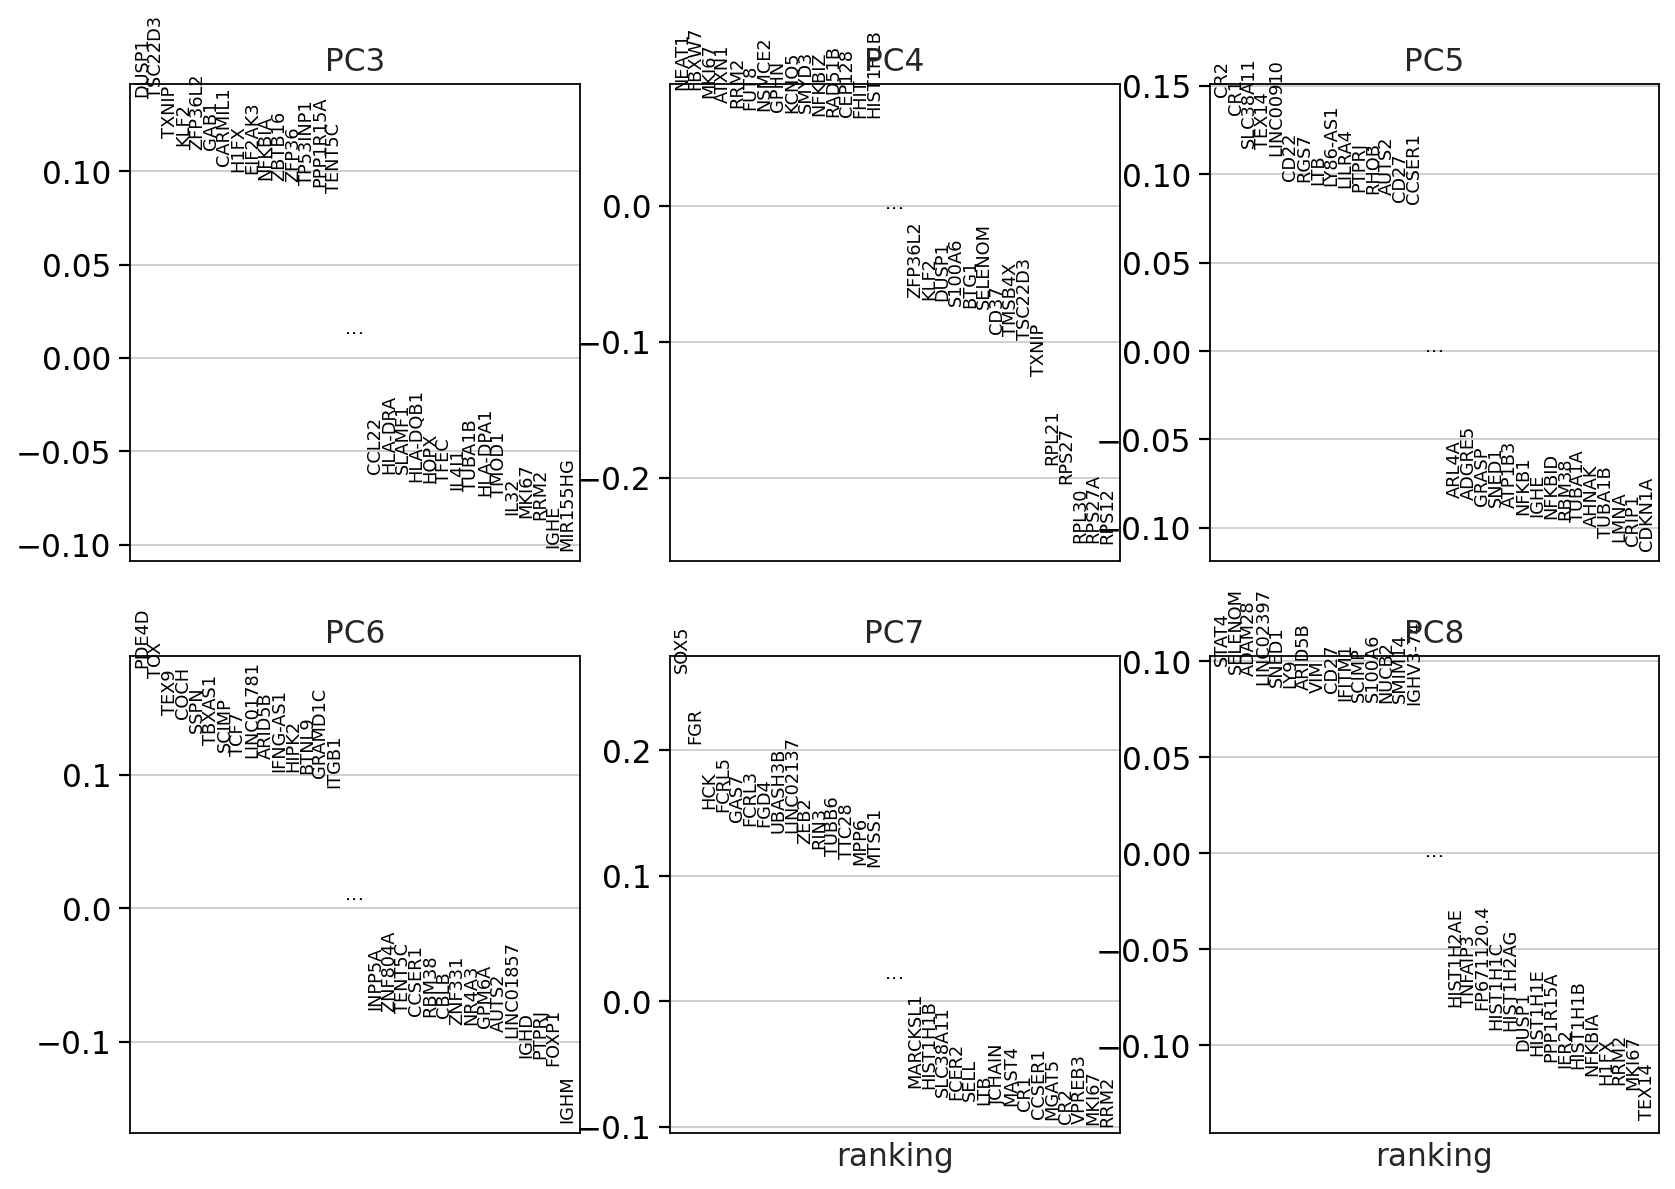

In [15]:
sc.pl.pca_loadings(adata, components='3,4,5,6,7,8')

In [16]:
adata = cluster(adata, batch_correct=False, batch_key="donor", pca = False)

drawing neighbor graph
UMAP-ing
leiden-ing


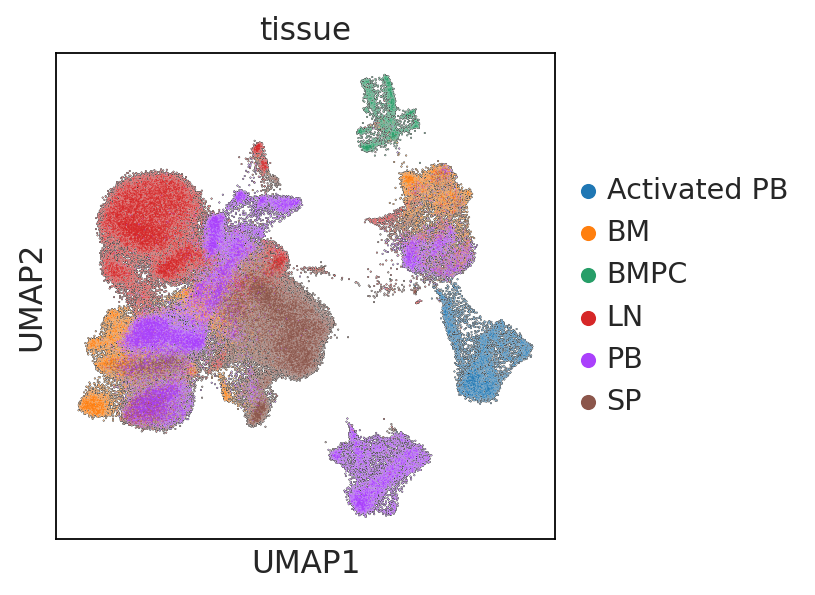

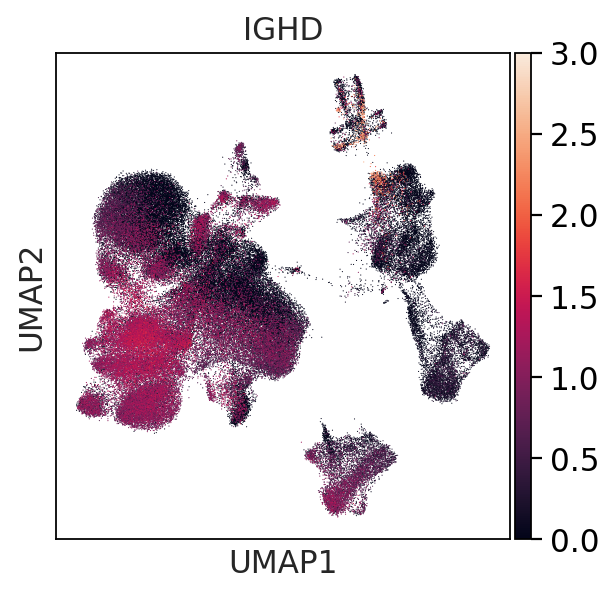

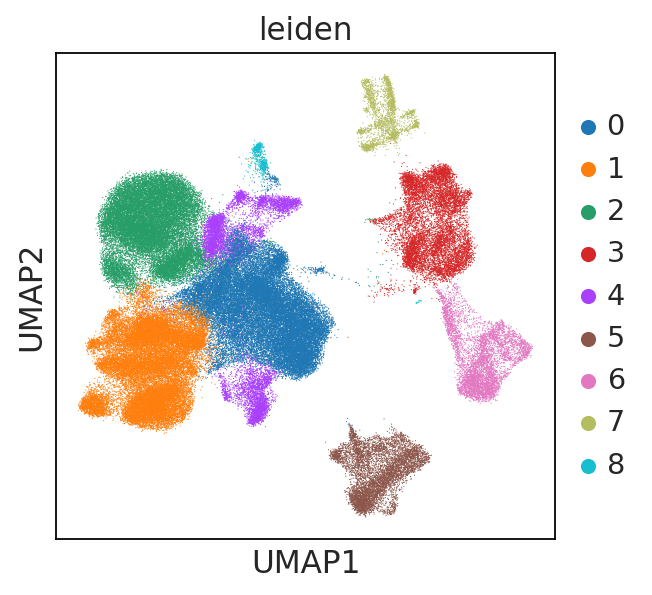

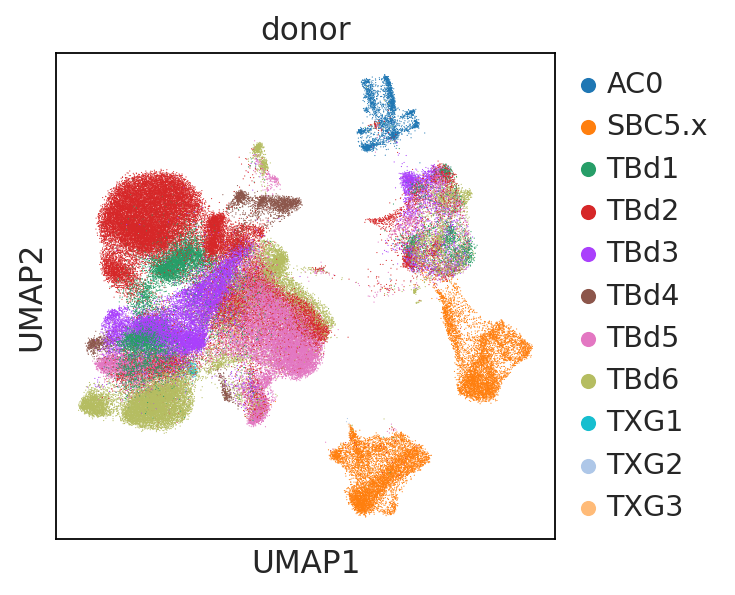

In [17]:
sc.pl.umap(adata, color = 'tissue', alpha = 0.5, add_outline=True)
sc.pl.umap(adata, color = 'IGHD', alpha = 1, vmax = 3)
sc.pl.umap(adata, color = 'leiden', alpha = 1, vmax = 3)
sc.pl.umap(adata, color = 'donor', alpha = 1, vmax = 3)

In [18]:
adata.obs.sample_uid.value_counts()

TBd5_frozen_SP     16908
TBd2_frozen_LN2    15050
L01_Input           6637
TBd2_frozen_LN1     5825
TBd6_fresh_SPL      5619
TBd6_fresh_LN       4882
TBd6_fresh_PBMC     4835
TBd2_frozen_SPa     4695
L04_T4              3986
TBd1_frozen_LNa     3312
TBd3_fresh_P50      3185
TBd6_fresh_BM       2888
TBd2_frozen_PB2     2849
TBd3_frozen_PBa     2811
TBd2_frozen_SPb     2754
TBd3_frozen_PBb     2559
TBd3_frozen_BMa     2291
TBd1_frozen_PBa     2137
TBd1_frozen_LNb     2071
BMPC_L2             1993
TBd5_frozen_BM      1829
TBd3_frozen_BMb     1698
TBd2_frozen_PB1     1491
TBd4_frozen_PBb     1244
TBd3_fresh_B20      1216
TBd1_frozen_PBb     1181
TBd3_fresh_P6       1104
L06_T8              1092
TBd1_frozen_BMa      994
TBd2_frozen_BMa      854
TBd4_frozen_PBa      768
TBd1_frozen_BMb      742
TBd4_frozen_BMb      664
TBd2_frozen_BMb      550
TBd4_frozen_BMa      537
BMPC_L1              513
L08_T12              451
20K_PBMC             316
10K_BMMNC            264
10K_PBMC             162


In [19]:
adata.write_h5ad("bcells_BCD.h5ad")

In [20]:
adata.obs.groupby('donor').majority_voting.value_counts().xs('SBC5.x')

Proliferative germinal center B cells    3979
Age-associated B cells                   3187
Naive B cells                            3002
Plasmablasts                              777
Memory B cells                            651
Plasma cells                              495
Migratory DCs                              74
pDC                                         1
Age-associated B cells|Naive B cells        0
Classical monocytes                         0
Memory B cells|Naive B cells                0
Memory B cells|Plasma cells                 0
Unassigned                                  0
Name: majority_voting, dtype: int64

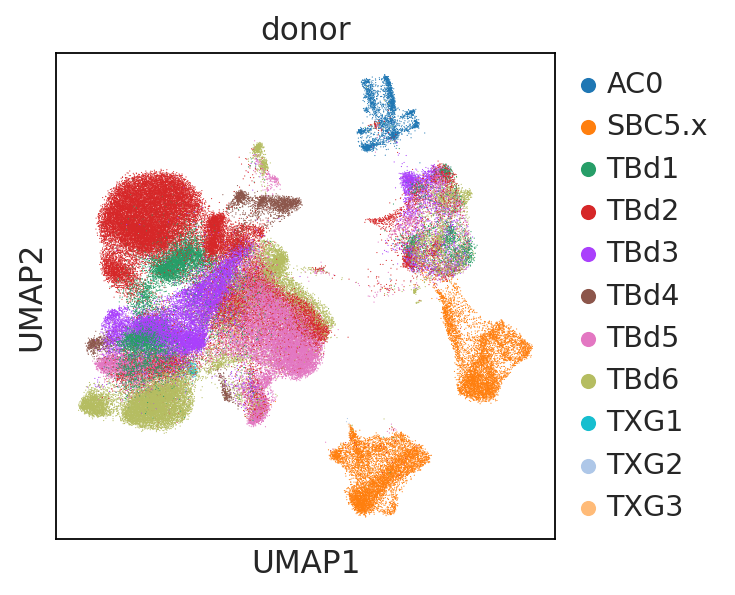

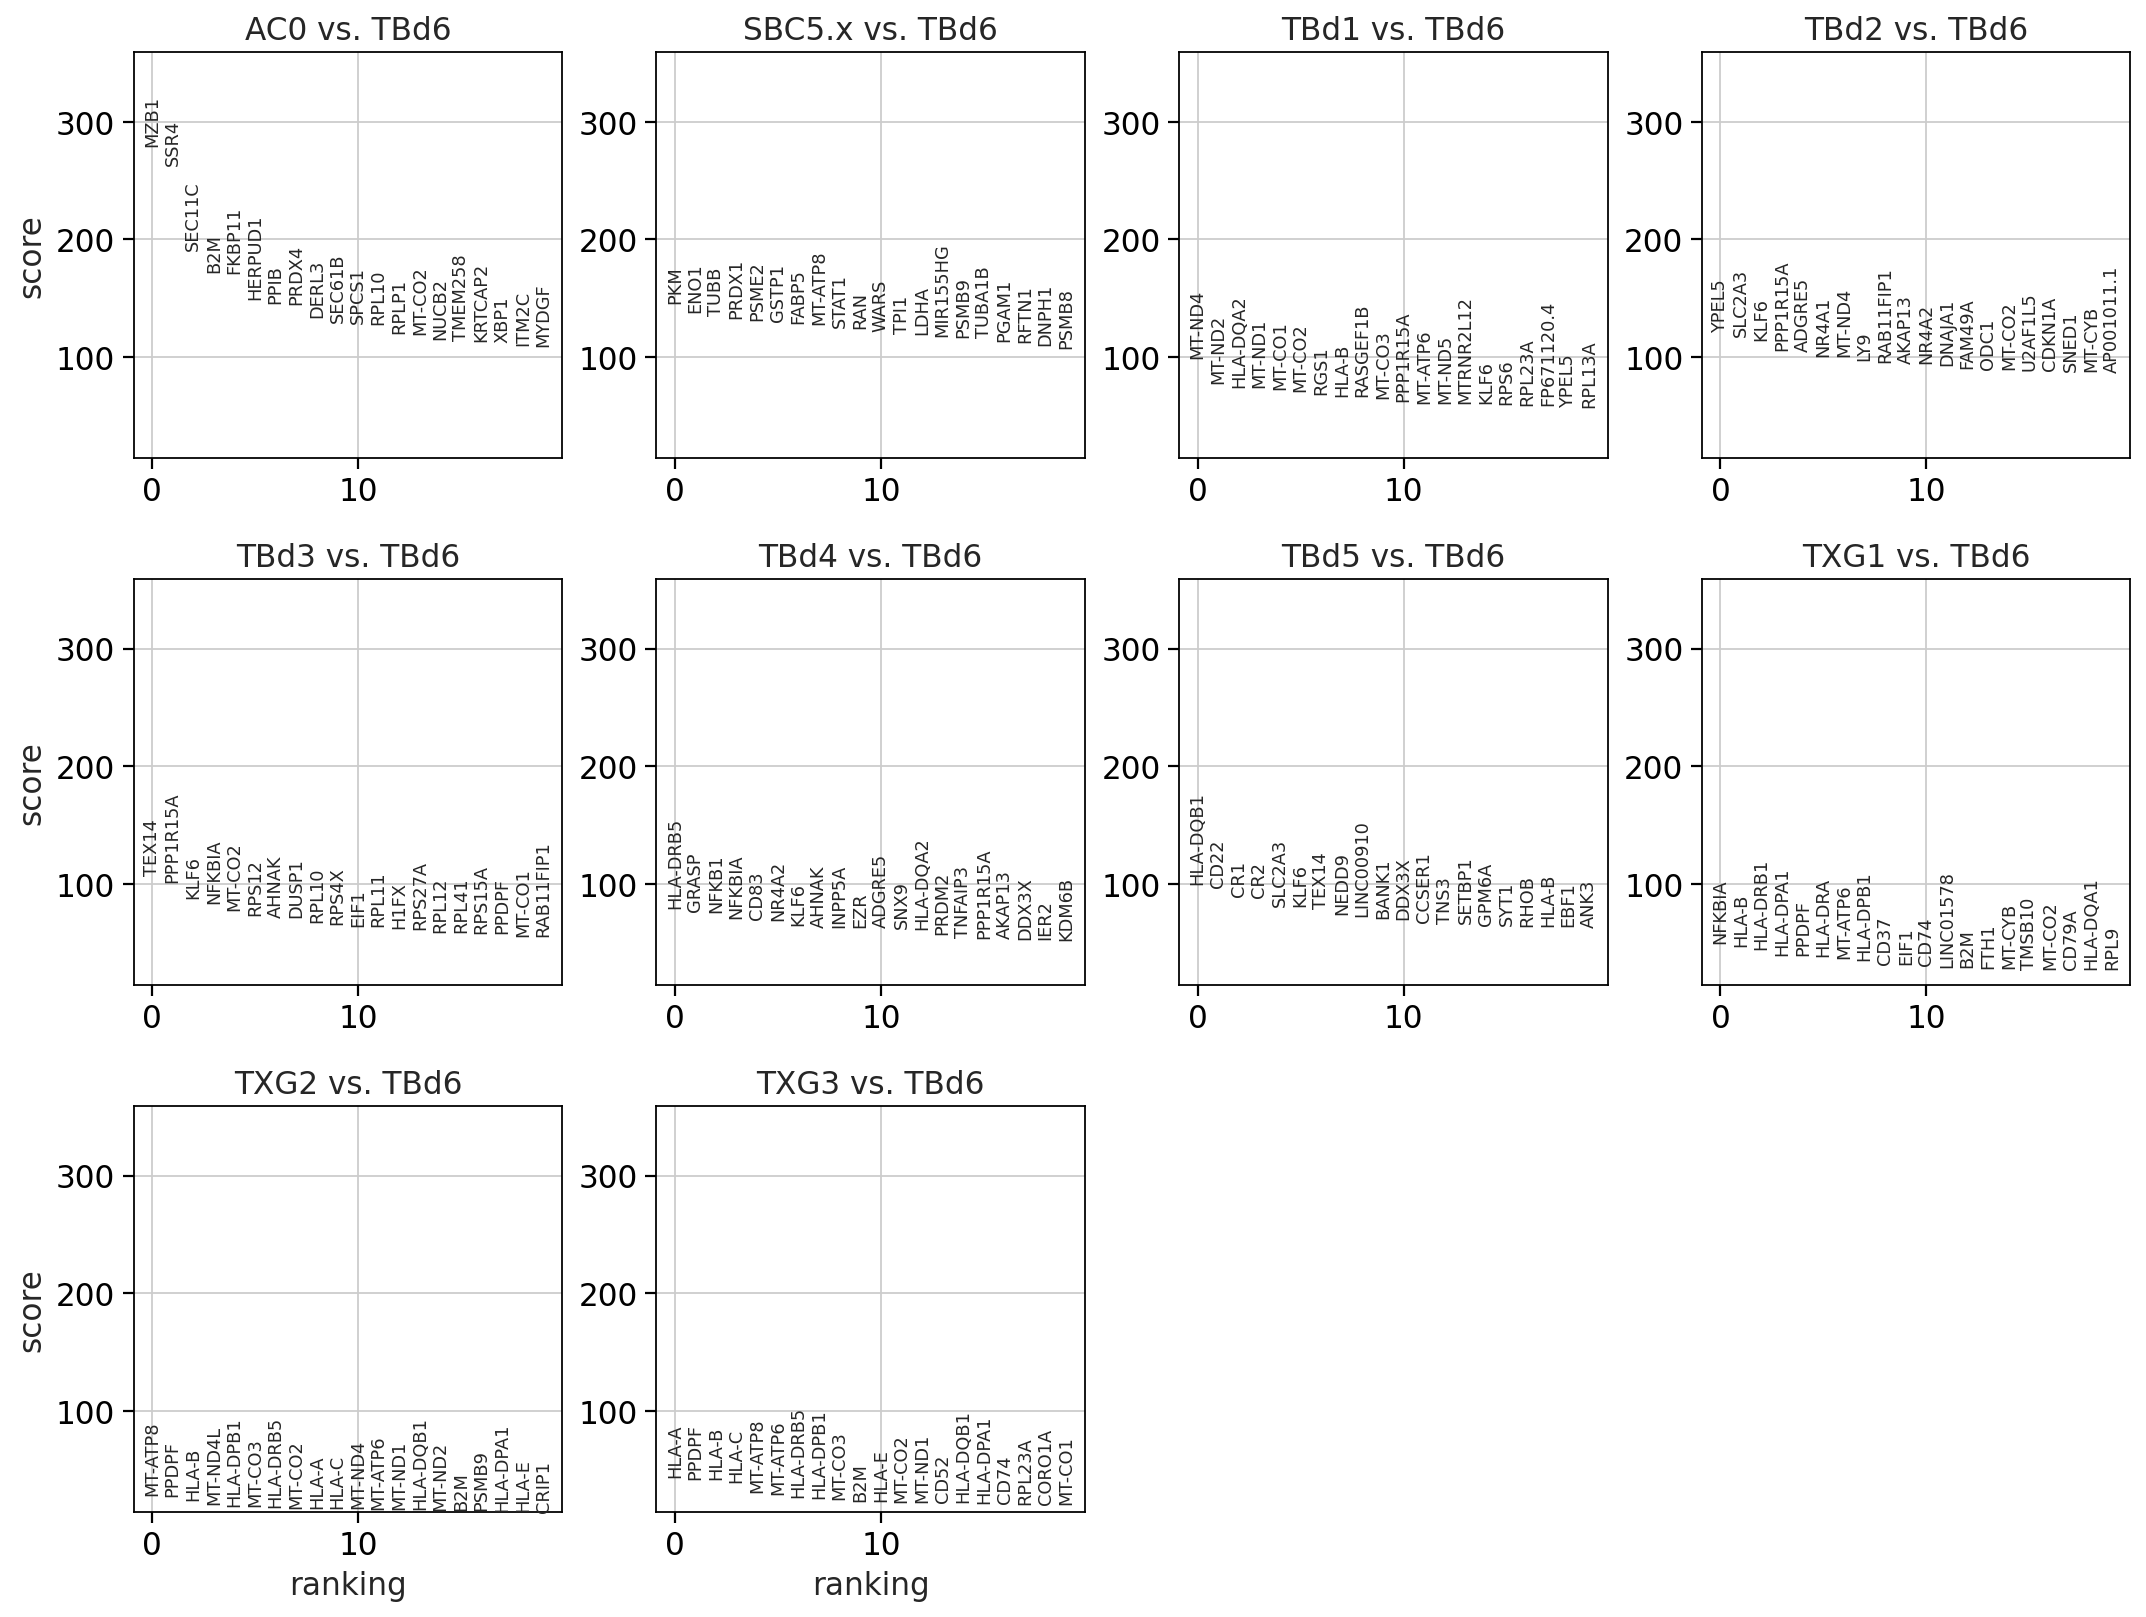

In [21]:
sc.pl.umap(adata, color = 'donor')

sc.tl.rank_genes_groups(adata, groupby='donor', reference='TBd6')

sc.pl.rank_genes_groups(adata)

In [23]:
sc.pl.umap(adata, color = ['XIST', 'RPS26'], save="donor_variability_2")


KeyError: 'XIST'

<Figure size 772.8x320 with 0 Axes>

In [ ]:
sc.pl.umap(adata, color = 'IL7R')

sc.pl.umap(adata, color = 'CD3E')
sc.pl.umap(adata, color = 'FYB1')


In [ ]:
sc.pl.umap(adata, color = 'leiden', size = 10)

sc.tl.rank_genes_groups(adata, groupby='leiden', reference='12')

sc.pl.rank_genes_groups(adata)

In [ ]:
sc.pl.umap(adata, color = ['DUSP1', 'SDC1', 'CD63'])

In [ ]:
sc.pl.umap(adata, color = ['tissue'])

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='leiden')

sc.pl.rank_genes_groups(adata)

In [ ]:
sc.pl.umap(adata, color = 'SOX5', size = 10)

sc.pl.umap(adata, color = 'CD27', size = 10)

sc.pl.umap(adata, color = 'sample_uid', size = 10)

sc.pl.umap(adata, color = 'majority_voting', size = 10)


In [ ]:
sc.pl.umap(adata, color = "MKI67", vmax=1, size = 10)
sc.pl.umap(adata, color = "tissue", size=10)
sc.pl.umap(adata, color = "SDC1",size=10)

In [ ]:
sc.pl.umap(adata, color = "AICDA")

In [ ]:
group = "tissue"
label = "leiden"
color = label
data = pd.DataFrame(adata.obs.groupby([group])[label].value_counts(normalize=True))
data.columns = ["dummy"]
data.reset_index(inplace=True)
data.columns = [group, label,"proportion"]
sns.axes_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(5,5))

sns.pointplot(
    y=group,
    x="proportion",
    hue=label,
    data=data,join = False, dodge=0.5, palette=adata.uns['{}_colors'.format(label)])

plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Proportion of Cells")
plt.ylabel("sample_id")
sc.pl.umap(adata, color = 'leiden')

In [ ]:
sc.pl.umap(adata, color = 'majority_voting')

In [ ]:
group = "donor"
label = "leiden"
color = label
data = pd.DataFrame(adata.obs.groupby([group])[label].value_counts(normalize=True))
data.columns = ["dummy"]
data.reset_index(inplace=True)
data.columns = [group, label,"proportion"]
sns.axes_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(5,5))

sns.pointplot(
    y=group,
    x="proportion",
    hue=label,
    data=data,join = False, dodge=0.5, palette=adata.uns['{}_colors'.format(label)])

plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Proportion of Cells")
plt.ylabel("sample_id")
sc.pl.umap(adata, color = 'leiden')

In [ ]:
COI = '12'

In [ ]:
group = "tissue"
label = "leiden"
color = label
data = pd.DataFrame(adata.obs.groupby([group])[label].value_counts(normalize=True))
data.columns = ["dummy"]
data.reset_index(inplace=True)
data.columns = [group, label,"proportion"]
sns.axes_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(5,10))
data = data[data[label] == COI]
sns.pointplot(
    y=group,
    x="proportion",
    hue=label,
    data=data,join = False, dodge=0.5, palette=adata.uns['{}_colors'.format(label)])

plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Number of Cells")
plt.ylabel("sample_id")
sc.pl.umap(adata, color = 'leiden')

In [ ]:
umap_color_1_leiden(adata, '13')

In [ ]:
sc.pl.stacked_violin(adata, var_names = ['CCL17','MS4A1','AICDA'], groupby='tissue', stripplot=True)
sc.pl.stacked_violin(adata, var_names = ['CCL17','MS4A1','AICDA'], groupby='sample_uid', stripplot=True)

In [ ]:
sc.pl.umap(adata, color = 'majority_voting')

In [ ]:
group1 = "donor"
group2 = 'tissue'
group3 = 'sample_uid'
label = "majority_voting"
color = label
data = pd.DataFrame(adata.obs.groupby([group1, group2, group3])[label].value_counts(normalize=True))
data.columns = ["dummy"]
data.reset_index(inplace=True)
data.columns = [group1, group2, group3, label,"proportion"]
sns.axes_style("white")
sns.set_style("ticks")
sns.catplot(
    y=group2,
    x="proportion",
    hue=label,
    col=group1,
    data=data, kind='point', join=False, palette=adata.uns['{}_colors'.format(label)])

plt.xscale("log")
plt.xlabel("Proportion of Cells")

# Human Variation By Tissue Cell Types

In [ ]:
group1 = "donor"
group2 = 'tissue'
group3 = 'sample_uid'
label = "majority_voting"
color = label
data = pd.DataFrame(adata.obs.groupby([group1, group2, group3])[label].value_counts(normalize=True))
data.columns = ["dummy"]
data.reset_index(inplace=True)
data.columns = [group1, group2, group3, label,"proportion"]
sns.axes_style("white")
sns.set_style("ticks")
sns.catplot(
    y=group2,
    x="proportion",
    hue=label,
    data=data, kind='swarm',palette=adata.uns['{}_colors'.format(label)], aspect=2)

plt.xscale("log")
plt.xlabel("Proportion of Cells")

In [ ]:
group1 = "donor"
group2 = 'tissue'
group3 = 'sample_uid'
label = "majority_voting"
color = label
data = pd.DataFrame(adata.obs.groupby([group1, group2, group3])[label].value_counts(normalize=True))
data.columns = ["dummy"]
data.reset_index(inplace=True)
data.columns = [group1, group2, group3, label,"proportion"]
sns.axes_style("white")
sns.set_style("ticks")
sns.catplot(
    y=group2,
    x="proportion",
    hue=group1,
    col = label,
    data=data, kind='strip',palette=adata.uns['{}_colors'.format(label)], aspect=2)

plt.xscale("log")
plt.xlabel("Proportion of Cells")

In [ ]:
group1 = "donor"
group2 = 'tissue'
group3 = 'sample_uid'
label = "majority_voting"
color = label
data = pd.DataFrame(adata.obs.groupby([group1, group2, group3])[label].value_counts(normalize=True))
data.columns = ["dummy"]
data.reset_index(inplace=True)
data.columns = [group1, group2, group3, label,"proportion"]
sns.axes_style("white")
sns.set_style("ticks")
sns.catplot(
    y=group2,
    x="proportion",
    hue=label,
    data=data, kind='box',palette=adata.uns['{}_colors'.format(label)], aspect=2, height=5)

plt.xscale("log")
plt.xlabel("Proportion of Cells")

In [ ]:
group1 = "donor"
group2 = 'tissue'
group3
label = "majority_voting"
color = label
data = pd.DataFrame(adata.obs.groupby([group1, group2])[label].value_counts(normalize=True))
data.columns = ["dummy"]
data.reset_index(inplace=True)
data.columns = [group1, group2, label,"proportion"]
sns.axes_style("white")
sns.set_style("ticks")
g = sns.catplot(
    y=group2,
    x="proportion",
    hue=label,
    data=data, kind='swarm', palette=adata.uns['{}_colors'.format(label)], height=7, aspect=1.5)

plt.xscale("log")
plt.xlabel("Proportion of Cells")

In [ ]:
group = "tissue"
label = "majority_voting"
color = label
data = pd.DataFrame(adata.obs.groupby([group])[label].value_counts(normalize=True))
data.columns = ["dummy"]
data.reset_index(inplace=True)
data.columns = [group, label,"proportion"]
sns.axes_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(5,5))

sns.pointplot(
    y=group,
    x="proportion",
    hue=label,
    data=data,join = False, dodge=0.5, palette=adata.uns['{}_colors'.format(label)])

plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Proportion of Cells")
plt.ylabel("sample_id")
sc.pl.umap(adata, color = 'leiden')
hm = data.pivot(index = group, columns=label)
sns.clustermap(hm, figsize=(12,12))

In [ ]:
group = "sample_uid"
label = "leiden"
color = label
data = pd.DataFrame(adata.obs.groupby([group])[label].value_counts(normalize=True))
data.columns = ["dummy"]
data.reset_index(inplace=True)
data.columns = [group, label,"proportion"]
sns.axes_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(5,10))

sns.pointplot(
    y=group,
    x="proportion",
    hue=label,
    data=data,join = False, dodge=0.5, palette=adata.uns['{}_colors'.format(label)])

plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Proportion of Cells")
plt.ylabel("sample_id")
sc.pl.umap(adata, color = 'leiden')

hm = data.pivot(index = 'sample_uid', columns='leiden')

sns.clustermap(hm)

In [ ]:
scipy.stats.spearmanr

In [ ]:
sub_data = data[data.proportion > 0.03]
sub_data.celltype = sub_data.celltype.cat.remove_unused_categories()
sns.axes_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.barplot(
    y="sample_id",
    x="proportion",
    hue="celltype",
    data=sub_data,)

#plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Proportion of Cells")
plt.ylabel("sample_id")


fig, ax = plt.subplots(1, 1, figsize=(5,5))

sns.pointplot(
    y="sample_id",
    x="proportion",
    hue="celltype",
    data=sub_data,join = False, dodge=0.2, palette='Dark2')

plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Proportion of Cells")
plt.ylabel("sample_id")


In [ ]:
adata.write_h5ad("bcells.h5ad")

In [ ]:
def ecdf_compare_bg(adata, gene):
    _umi = sc.get.obs_df(bcells, keys = gene, layer='umi_counts')
    _bg = sc.get.obs_df(bcells, keys = gene, layer='background_removed')
    data = pd.concat([_bg, _umi], axis=1)
    data.columns = ['cbender', 'umi']
    data = data.melt()
    sns.displot(data, x = 'value', hue = 'variable', kind = 'ecdf', log_scale=True)

In [ ]:
adata = sc.read_h5ad('bcells.h5ad')

## Tissue Analysis

In [26]:
import os

In [28]:
cell_type = 'Memory B cells'
column_name = 'majority_voting'

In [29]:
label = 'donor'
cell_type = 'Memory B cells'

In [33]:
adata.obs

sample_uid donor tissue leiden             predicted_labels  \
CCATGTCTCTGTCTAT-1     TBd3_fresh_B20  TBd3     BM      1  Naive B cells|Promyelocytes   
CTCGTACGTGATGTGG-1      TBd6_fresh_BM  TBd6     BM      3                 Plasma cells   
CGATGGCAGACCCACC-1-1  TBd1_frozen_BMb  TBd1     BM      3                 Plasma cells   
CTTGGCTTCACCTCGT-1     TBd3_fresh_B20  TBd3     BM      3                 Plasmablasts   
TTGGAACGTCCATCCT-1    TBd4_frozen_BMb  TBd4     BM      1                Naive B cells   
...                               ...   ...    ...    ...                          ...   
TATTACCTCCGCTGTT-1    TBd1_frozen_PBa  TBd1     PB      1                Naive B cells   
AGACGTTGTTCTGAAC-1    TBd4_frozen_PBa  TBd4     PB      4                   Unassigned   
GGTATTGAGTTATCGC-1    TBd3_frozen_PBa  TBd3     PB      1                Naive B cells   
GCTGCGAAGGCCCTTG-1    TBd1_frozen_BMa  TBd1     PB      1                Naive B cells   
CTCGGAGAGGCTACGA-1    TBd3_frozen_PBa  TBd3     PB      0               Memory B cells   

                             majority_voting  conf_score  over_clustering donor_tissue  \
CCATGTCTCTGTCTAT-1             Naive B cells    1.000000              102       TBd3BM   
CTCGTACGTGATGTGG-1              Plasma cells    1.000000               75       TBd6BM   
CGATGGCAGACCCACC-1-1            Plasma cells    0.999978               13       TBd1BM   
CTTGGCTTCACCTCGT-1              Plasmablasts    0.958423               12       TBd3BM   
TTGGAACGTCCATCCT-1             Naive B cells    1.000000               82       TBd4BM   
...                                      ...         ...              ...          ...   
TATTACCTCCGCTGTT-1             Naive B cells    0.999481              164       TBd1PB   
AGACGTTGTTCTGAAC-1    Age-associated B cells    0.204514               53       TBd4PB   
GGTATTGAGTTATCGC-1             Naive B cells    1.000000              353       TBd3PB   
GCTGCGAAGGCCCTTG-1             Naive B cells    1.000000               67       TBd1PB   
CTCGGAGAGGCTACGA-1            Memory B cells    0.927855               98       TBd3PB   

                      _scvi_batch  _scvi_labels  n_genes_by_counts  log1p_n_genes_by_counts  \
CCATGTCTCTGTCTAT-1             10             0               1454                 7.282761   
CTCGTACGTGATGTGG-1             16             0               4866                 8.490233   
CGATGGCAGACCCACC-1-1            3             0               1396                 7.242082   
CTTGGCTTCACCTCGT-1             10             0               1635                 7.400010   
TTGGAACGTCCATCCT-1             12             0               1536                 7.337588   
...                           ...           ...                ...                      ...   
TATTACCTCCGCTGTT-1              5             0               1295                 7.167038   
AGACGTTGTTCTGAAC-1             13             0               1737                 7.460490   
GGTATTGAGTTATCGC-1             11             0               1198                 7.089243   
GCTGCGAAGGCCCTTG-1              5             0               1985                 7.593878   
CTCGGAGAGGCTACGA-1             11             0               1200                 7.090910   

                      total_counts  log1p_total_counts  pct_counts_in_top_50_genes  \
CCATGTCTCTGTCTAT-1     1536.883423            7.338162                    5.548449   
CTCGTACGTGATGTGG-1     2020.944824            7.611815                    3.856623   
CGATGGCAGACCCACC-1-1   1522.337280            7.328659                    5.263846   
CTTGGCTTCACCTCGT-1     1602.697021            7.380067                    5.185118   
TTGGAACGTCCATCCT-1     1572.286011            7.360922                    5.120700   
...                            ...                 ...                         ...   
TATTACCTCCGCTGTT-1     1477.153931            7.298549                    5.586079   
AGACGTTGTTCTGAAC-1     1625.288696  

In [30]:
tissue_colors_dictionary = tissue_colors()

In [31]:
adata.obs_names_make_unique()

/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['CATGCCTTCCCTGACT-1-1', 'GACCTGGTCGGCTTGG-1-1', 'GACCTGGTCGGCTTGG-1-2', 'GGCTGGTCAGGCGATA-1-1', 'ATCACGAAGCACGCCT-1-1']
  warnings.warn(


In [32]:
_sub_adata = adata[adata.obs[column_name] == cell_type]
# subset to tissues with more than 10 cells detected in this class
# for reasonable differential epxression comparison
_df = pd.DataFrame(_sub_adata.obs.groupby(label)[column_name].value_counts() > 10)
_tissues = _df[_df[column_name] == True].unstack().index.to_list()
_sub_adata = _sub_adata[_sub_adata.obs.tissue.isin(_tissues)]
print("{} {} in the dataset {}".format(_sub_adata.obs.shape[0], cell_type, "after filtering out low abundance tissues"))

print("performing differential expression analysis")
min_fold_change = 0.8
# uses t-test for speed, but wilcoxon is the more appropriate test I'm told
sc.tl.rank_genes_groups(_sub_adata, groupby=label)
sc.tl.filter_rank_genes_groups(_sub_adata, min_fold_change=min_fold_change)
print("filtered genes by min fold change {}".format(min_fold_change))

sc.pl.rank_genes_groups(_sub_adata)
result = _sub_adata.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names
gene_df = pd.DataFrame(
    {group + '_' + key[:]: result[key][group]
     # Get Each Clusters 10 top Genes
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

holo_gene_set = []
num_genes = 30
result = _sub_adata.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names
gene_df = pd.DataFrame(
    {group + '_' + key[:]: result[key][group]
     # Get Each Clusters 10 top Genes
    for group in groups for key in ['names', 'pvals']})


#iterate thru the unique tissues
for tis in _sub_adata.obs[label].unique():

    # reset rank genes df for new organ
    _gene_df = gene_df.copy()
     # Drop the filtered genes
    _gene_df = _gene_df[[tis + '_names', tis + '_pvals']].dropna()
    gene_list = _gene_df[tis + '_names'].to_list()
    genes = gene_list
    holo_gene_set.append(gene_list)
    score_name = tis + '_' + cell_type + "_residence_score"
    sc.tl.score_genes(_sub_adata, gene_list = gene_list[:num_genes], score_name = score_name, use_raw = False)
    plotdf = sc.get.obs_df(
            _sub_adata,
            keys=genes + [label, score_name])
    for gene in genes[:2]:
        g = sns.displot(data = plotdf, x = gene, hue = label, kind='ecdf', palette=tissue_colors_dictionary
                   )
        g.set_titles(cell_type)
        g.set_xlabels(gene + ' expression')
        directory = 'figures/{}_specific/{}_{}/'.format(label, cell_type, tis)
        if not os.path.exists(directory):
            os.makedirs(directory)
        g.savefig('figures/{}_specific/{}_{}/{}.pdf'.format(label, cell_type, tis, gene))
    g = sns.displot(data = plotdf, x=score_name, hue = label, kind = 'ecdf', palette=tissue_colors_dictionary )
    g.savefig('figures/{}_specific/{}.pdf'.format(label, score_name))

0 Memory B cells in the dataset after filtering out low abundance tissues
performing differential expression analysis


/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


AttributeError: 'NoneType' object has no attribute 'columns'

In [ ]:
sc.pl.rank_genes_groups_dotplot(_sub_adata)

In [ ]:
sc.pl.umap(_sub_adata, color = 'LN_Memory B cells_residence_score')
sc.pl.umap(_sub_adata, color = 'SP_Memory B cells_residence_score')
sc.pl.umap(_sub_adata, color = 'PB_Memory B cells_residence_score')

sc.pl.umap(_sub_adata, color = 'tissue')

In [ ]:
tois = ['SP', 'LN']
hue = 'tissue'
data = _sub_adata.obs
data = data[data[hue].isin(tois)]
data[hue] = data[hue].cat.remove_unused_categories()
n = data[hue].value_counts().min()
data = data.groupby(hue).sample(n=n)
x = '{}_Memory B cells_residence_score'.format(tois[0])
y = '{}_Memory B cells_residence_score'.format(tois[1])
g = sns.jointplot(
        data=data, x=x, y=y, hue=hue, kind="kde", legend=True
    )



In [ ]:
sns.ecdfplot(data = data, x = x, hue = hue, complementary=True, stat='proportion')
plt.yscale('log')
plt.ylabel('number of cells')

In [ ]:
(data[data.tissue == 'PB']['SP_Memory B cells_residence_score'] > 0.3).value_counts()

In [ ]:
cells = data[data['SP_Memory B cells_residence_score'] > 0.3]
cells = cells[cells.tissue == 'PB']

In [ ]:
cells.shape

In [ ]:
_sub_adata.obs["circulating_SP_B?"] = _sub_adata.obs.index.isin(cells.index)

In [ ]:
_sub_adata.obs['circulating_SP_B?'] = _sub_adata.obs['circulating_SP_B?'].astype(str)

In [ ]:
sc.pl.stacked_violin(_sub_adata[_sub_adata.obs.tissue == 'PB'], var_names = ['CR1', 'CR2', 'CD22', 'LY9', 'CD27'], groupby='circulating_SP_B?')

In [ ]:
sc.pl.stacked_violin(_sub_adata[_sub_adata.obs.tissue == 'PB'], var_names = ['CR1', 'CR2', 'CD22', 'LY9', 'CD27', 'MS4A1'], groupby='circulating_SP_B?')
sc.pl.stacked_violin(_sub_adata[_sub_adata.obs.tissue == 'SP'], var_names = ['CR1', 'CR2', 'CD22', 'LY9', 'CD27', 'MS4A1'], groupby='circulating_SP_B?')

In [ ]:
_sub_adata.obs['SP_Mem_quantile'] = pd.qcut(_sub_adata.obs['SP_Memory B cells_residence_score'], q=3)
_sub_adata.obs['LN_Mem_quantile'] = pd.qcut(_sub_adata.obs['LN_Memory B cells_residence_score'], q=3)
_sub_adata.obs['PB_Mem_quantile'] = pd.qcut(_sub_adata.obs['PB_Memory B cells_residence_score'], q=3)

In [ ]:
tois = ['PB', 'LN']
quantile = ["SP"]
hue = 'tissue'
data = _sub_adata.obs
data = data[data[hue].isin(tois)]

data[hue] = data[hue].cat.remove_unused_categories()
n = data[hue].value_counts().min()
# reset hue
hue = '{}_Mem_quantile'.format(quantile[0])
x = '{}_Memory B cells_residence_score'.format(tois[0])
y = '{}_Memory B cells_residence_score'.format(tois[1])
g = sns.jointplot(
        data=data, x=x, y=y, hue=hue, kind="scatter", legend=True, alpha=0.5
    )

In [ ]:
sc.pl.umap(_sub_adata, color = ['LN_Mem_quantile', 'tissue'], ncols = 1)

In [ ]:
umap_color_1(_sub_adata, column_name='tissue', variable_name='LN')

In [ ]:
tois = ['PB', 'LN']
hue = 'tissue'
data = _sub_adata.obs
data = data[data[hue].isin(tois)]

data[hue] = data[hue].cat.remove_unused_categories()
n = data[hue].value_counts().min()
x = '{}_Memory B cells_residence_score'.format(tois[0])
y = '{}_Memory B cells_residence_score'.format(tois[1])
g = sns.jointplot(
        data=data, x=x, y=y, hue=hue, kind="scatter", legend=True, alpha=0.5
    )

In [ ]:
sns.plot(data = data, x = , y = 'PB_Memory B cells_residence_score', hue = 'tissue')

In [ ]:
_sub_adata.obs.groupby('tissue')['LN_Memory B cells_residence_score'].apply( lambda x: x*100 )

In [ ]:
## Do Plasmablasts in Blood express JCHAIN no matter their isotype what?

In [ ]:
import celltypist

In [ ]:
predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl',
                                  majority_voting=True, mode = 'prob match')

In [ ]:
adata = predictions.to_adata()

In [ ]:
tissue_colors_dictionary = tissue_colors()

In [ ]:
cell_type = "Plasma cells"
label = "tissue"
column_name = "predicted_label"

In [ ]:
# probable_B
# possible_B -> many B cell features but seems like garbage?
    # especially idk if this is a mem vs. naive etc.
    # or they are potentially doublets
# not_B_but_cell
# literal garbage
# B-T doublet